# Switching Policy Analysis

In [1]:
import Starbucks as sbs
import numpy as np
import numpy.random
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import Person as ppl
import Employee as emp
from scipy.optimize import minimize, basinhopping
import seaborn as sns

In [2]:
#Run simulation
a = sbs.Starbucks()
starbucksArrivalRate = 75
pMobile = 0.31
pCoffee = 0.1
cashRate = 62
barRate = 17.5
simDuration = 100
cTotal = 4
initialCashC = 1
numCashReg = 2
switchRatioCashtoBar = 0.5
switchRatioBartoCash = 1 
meanPatienceTime = 100 
vacationMeanLength = 1

a.simulation(starbucksArrivalRate, 
             pMobile,   
             pCoffee , 
             cashRate, 
             barRate ,     
             simDuration, 
             cTotal, 
             initialCashC, 
             numCashReg,
             switchRatioCashtoBar, 
             switchRatioBartoCash, 
             meanPatienceTime, 
             vacationMeanLength)

# Calculate Average Response and Wait Times

In [3]:
t = np.array(a.times)

In [4]:
def calc_wait_time(c):
    wait_time = 0
    if c.mobile == 1:
        return c.timeExitBarQ - c.timeEnterBarQ
    if c.mobile == 0 and c.coffee == 0:
        return c.timeExitBarQ - c.timeEnterBarQ + c.timeExitCashQ - c.timeEnterCashQ
    if c.mobile == 0 and c.coffee == 1:
        return c.timeExitCashQ - c.timeEnterCashQ
    
def calc_starbucks_time(c):
    return c.timeExitStbks - c.timeEnterStbks
        
def calc_cum_average_of_metric(metric):
    cum_average = np.cumsum(metric) / np.cumsum(np.arange(len(metric)))
    return cum_average

In [5]:
customer_wait_times = [calc_wait_time(c) for c in a.completedCustomers]
average_wait_time = calc_cum_average_of_metric(customer_wait_times)
customer_starbucks_times = [calc_starbucks_time(c) for c in a.completedCustomers]
average_starbucks_time = calc_cum_average_of_metric(customer_starbucks_times)

/home/malfrine/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  
/home/malfrine/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in true_divide
  


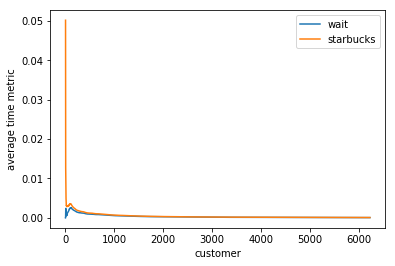

In [6]:
plt.figure()
plt.plot(average_wait_time, label = 'wait')
plt.plot(average_starbucks_time, label = 'starbucks')
plt.xlabel('customer')
plt.ylabel('average time metric')
plt.legend()
plt.show()

In [7]:
bq = np.array(a.barqlength)
cq = np.array(a.cashqlength)

In [8]:
def calc_average_queue_length(q, t):
    return np.cumsum(q[1:] * (t[1:] - t[:-1])) / np.cumsum(t[:-1])

In [9]:
avg_bq = calc_average_queue_length(bq, t)
avg_cq = calc_average_queue_length(cq, t)

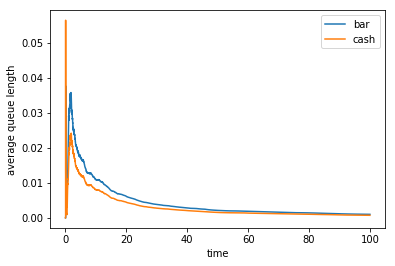

In [10]:
plt.figure()
plt.plot(t[1:], avg_bq, label='bar')
plt.plot(t[1:], avg_cq, label='cash')
plt.legend()
plt.xlabel('time')
plt.ylabel('average queue length')
plt.show()

For system to reach steady state - sim duration = 50 hours 

# Optimize Switching Ratios

In [11]:
def opt_func(x, pMobile = 0.31, pCoffee = 0.1, rng_seed = 0):
    # x is an array with length 2
    # first element is the ratio for when to switch from cash to bar, second is bar to cash
    switchRatioCashtoBar, switchRatioBartoCash = x[0], x[1]
    #Run simulation
    a = sbs.Starbucks()
    starbucksArrivalRate = 75
    cashRate = 62
    barRate = 17.5
    simDuration = 30
    cTotal = 4
    initialCashC = 1
    numCashReg = 2 
    meanPatienceTime = 100 
    vacationMeanLength = 1

    if rng_seed is None:
        a.simulation(starbucksArrivalRate, 
                 pMobile,   
                 pCoffee , 
                 cashRate, 
                 barRate ,     
                 simDuration, 
                 cTotal, 
                 initialCashC, 
                 numCashReg,
                 switchRatioCashtoBar, 
                 switchRatioBartoCash, 
                 meanPatienceTime, 
                 vacationMeanLength)
    else:
        np.random.seed(rng_seed)
        a.simulation(starbucksArrivalRate, 
                     pMobile,   
                     pCoffee , 
                     cashRate, 
                     barRate ,     
                     simDuration, 
                     cTotal, 
                     initialCashC, 
                     numCashReg,
                     switchRatioCashtoBar, 
                     switchRatioBartoCash, 
                     meanPatienceTime, 
                     vacationMeanLength)
    
    customer_starbucks_times = [calc_starbucks_time(c) for c in a.completedCustomers]
    
    return np.mean(customer_starbucks_times)
    
    
    

In [12]:
opt_func(np.array([1, 1]))

0.19953520441434827

In [13]:
p_mobiles = [0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
p_coffees = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]
c2b_df = pd.DataFrame(index=p_coffees, columns=p_mobiles)
b2c_df = pd.DataFrame(index=p_coffees, columns=p_mobiles)
fun_df = pd.DataFrame(index=p_coffees, columns=p_mobiles)

In [14]:
# set bounds
xmin = [0., 0.]
xmax = [10., 10.]

# rewrite the bounds in the way required by L-BFGS-B
bounds = [(low, high) for low, high in zip(xmin, xmax)]

# use method L-BFGS-B because the problem is smooth and bounded
minimizer_kwargs = dict(bounds=bounds)

In [ ]:
for pm in p_mobiles:
    for pc in p_coffees:
        sol = basinhopping(lambda x: opt_func(x, pMobile=pm, pCoffee=pc), 
                           np.array([1, 0.5]), 
                           minimizer_kwargs = dict(bounds=bounds), 
                           disp=True)
        print(pc, pm)
        c2b_df.loc[pc, pm] = sol.lowest_optimization_result.x[0]
        b2c_df.loc[pc, pm] = sol.lowest_optimization_result.x[1]
        fun_df.loc[pc, pm] = sol.lowest_optimization_result.fun

basinhopping step 0: f 0.207629
basinhopping step 1: f 0.185621 trial_f 0.185621 accepted 1  lowest_f 0.185621
found new global minimum on step 1 with function value 0.185621
basinhopping step 2: f 0.302248 trial_f 0.302248 accepted 1  lowest_f 0.185621
basinhopping step 3: f 0.27752 trial_f 0.27752 accepted 1  lowest_f 0.185621
basinhopping step 4: f 0.246796 trial_f 0.246796 accepted 1  lowest_f 0.185621
basinhopping step 5: f 0.234916 trial_f 0.234916 accepted 1  lowest_f 0.185621
basinhopping step 6: f 0.20256 trial_f 0.20256 accepted 1  lowest_f 0.185621
basinhopping step 7: f 0.25557 trial_f 0.25557 accepted 1  lowest_f 0.185621
basinhopping step 8: f 0.261657 trial_f 0.261657 accepted 1  lowest_f 0.185621
basinhopping step 9: f 0.301303 trial_f 0.301303 accepted 1  lowest_f 0.185621
basinhopping step 10: f 0.167617 trial_f 0.167617 accepted 1  lowest_f 0.167617
found new global minimum on step 10 with function value 0.167617
basinhopping step 11: f 0.20306 trial_f 0.20306 accept

basinhopping step 97: f 0.147427 trial_f 0.147427 accepted 1  lowest_f 0.138337
basinhopping step 98: f 0.1437 trial_f 0.1437 accepted 1  lowest_f 0.138337
basinhopping step 99: f 0.146338 trial_f 0.146338 accepted 1  lowest_f 0.138337
adaptive stepsize: acceptance rate 0.950000 target 0.500000 new stepsize 0.617284 old stepsize 0.555556
basinhopping step 100: f 0.165283 trial_f 0.165283 accepted 1  lowest_f 0.138337
0.1 0.2
basinhopping step 0: f 0.157584
basinhopping step 1: f 0.130459 trial_f 0.130459 accepted 1  lowest_f 0.130459
found new global minimum on step 1 with function value 0.130459
basinhopping step 2: f 0.3093 trial_f 0.3093 accepted 1  lowest_f 0.130459
basinhopping step 3: f 0.14248 trial_f 0.14248 accepted 1  lowest_f 0.130459
basinhopping step 4: f 0.146531 trial_f 0.146531 accepted 1  lowest_f 0.130459
basinhopping step 5: f 0.146531 trial_f 0.806777 accepted 0  lowest_f 0.130459
basinhopping step 6: f 0.224114 trial_f 0.224114 accepted 1  lowest_f 0.130459
basinho

basinhopping step 95: f 0.181786 trial_f 0.181786 accepted 1  lowest_f 0.115689
basinhopping step 96: f 0.188195 trial_f 0.188195 accepted 1  lowest_f 0.115689
basinhopping step 97: f 0.197815 trial_f 0.197815 accepted 1  lowest_f 0.115689
basinhopping step 98: f 0.146175 trial_f 0.146175 accepted 1  lowest_f 0.115689
basinhopping step 99: f 0.193306 trial_f 0.193306 accepted 1  lowest_f 0.115689
adaptive stepsize: acceptance rate 0.930000 target 0.500000 new stepsize 0.617284 old stepsize 0.555556
basinhopping step 100: f 0.140701 trial_f 0.140701 accepted 1  lowest_f 0.115689
0.15 0.2
basinhopping step 0: f 0.104911
basinhopping step 1: f 0.142429 trial_f 0.142429 accepted 1  lowest_f 0.104911
basinhopping step 2: f 0.187691 trial_f 0.187691 accepted 1  lowest_f 0.104911
basinhopping step 3: f 0.12689 trial_f 0.12689 accepted 1  lowest_f 0.104911
basinhopping step 4: f 0.177402 trial_f 0.177402 accepted 1  lowest_f 0.104911
basinhopping step 5: f 0.195781 trial_f 0.195781 accepted 1 

basinhopping step 94: f 0.173955 trial_f 0.173955 accepted 1  lowest_f 0.104911
basinhopping step 95: f 0.174603 trial_f 0.174603 accepted 1  lowest_f 0.104911
basinhopping step 96: f 0.173955 trial_f 0.173955 accepted 1  lowest_f 0.104911
basinhopping step 97: f 0.174603 trial_f 0.174603 accepted 1  lowest_f 0.104911
basinhopping step 98: f 0.173955 trial_f 0.173955 accepted 1  lowest_f 0.104911
basinhopping step 99: f 0.174603 trial_f 0.174603 accepted 1  lowest_f 0.104911
adaptive stepsize: acceptance rate 0.990000 target 0.500000 new stepsize 0.617284 old stepsize 0.555556
basinhopping step 100: f 0.173955 trial_f 0.173955 accepted 1  lowest_f 0.104911
0.2 0.2
basinhopping step 0: f 0.117659
basinhopping step 1: f 0.115392 trial_f 0.115392 accepted 1  lowest_f 0.115392
found new global minimum on step 1 with function value 0.115392
basinhopping step 2: f 0.115392 trial_f 0.14982 accepted 0  lowest_f 0.115392
basinhopping step 3: f 0.118515 trial_f 0.118515 accepted 1  lowest_f 0.11

basinhopping step 91: f 0.182654 trial_f 0.182654 accepted 1  lowest_f 0.0940637
basinhopping step 92: f 0.128896 trial_f 0.128896 accepted 1  lowest_f 0.0940637
basinhopping step 93: f 0.119446 trial_f 0.119446 accepted 1  lowest_f 0.0940637
basinhopping step 94: f 0.108616 trial_f 0.108616 accepted 1  lowest_f 0.0940637
basinhopping step 95: f 0.104926 trial_f 0.104926 accepted 1  lowest_f 0.0940637
basinhopping step 96: f 0.114881 trial_f 0.114881 accepted 1  lowest_f 0.0940637
basinhopping step 97: f 0.103328 trial_f 0.103328 accepted 1  lowest_f 0.0940637
basinhopping step 98: f 0.124948 trial_f 0.124948 accepted 1  lowest_f 0.0940637
basinhopping step 99: f 0.100697 trial_f 0.100697 accepted 1  lowest_f 0.0940637
adaptive stepsize: acceptance rate 0.960000 target 0.500000 new stepsize 0.617284 old stepsize 0.555556
basinhopping step 100: f 0.179952 trial_f 0.179952 accepted 1  lowest_f 0.0940637
0.25 0.2
basinhopping step 0: f 0.106958
basinhopping step 1: f 0.0943676 trial_f 0.0

basinhopping step 83: f 0.094273 trial_f 0.094273 accepted 1  lowest_f 0.0791594
basinhopping step 84: f 0.0890349 trial_f 0.0890349 accepted 1  lowest_f 0.0791594
basinhopping step 85: f 0.0973294 trial_f 0.0973294 accepted 1  lowest_f 0.0791594
basinhopping step 86: f 0.0887029 trial_f 0.0887029 accepted 1  lowest_f 0.0791594
basinhopping step 87: f 0.0887029 trial_f 0.0887029 accepted 1  lowest_f 0.0791594
basinhopping step 88: f 0.0890349 trial_f 0.0890349 accepted 1  lowest_f 0.0791594
basinhopping step 89: f 0.094273 trial_f 0.094273 accepted 1  lowest_f 0.0791594
basinhopping step 90: f 0.0901381 trial_f 0.0901381 accepted 1  lowest_f 0.0791594
basinhopping step 91: f 0.0891442 trial_f 0.0891442 accepted 1  lowest_f 0.0791594
basinhopping step 92: f 0.0901381 trial_f 0.0901381 accepted 1  lowest_f 0.0791594
basinhopping step 93: f 0.0891442 trial_f 0.0891442 accepted 1  lowest_f 0.0791594
basinhopping step 94: f 0.0891442 trial_f 0.0891442 accepted 1  lowest_f 0.0791594
basinhop

basinhopping step 79: f 0.0910038 trial_f 0.0910038 accepted 1  lowest_f 0.0882757
basinhopping step 80: f 0.0840839 trial_f 0.0840839 accepted 1  lowest_f 0.0840839
found new global minimum on step 80 with function value 0.0840839
basinhopping step 81: f 0.0947927 trial_f 0.0947927 accepted 1  lowest_f 0.0840839
basinhopping step 82: f 0.0914568 trial_f 0.0914568 accepted 1  lowest_f 0.0840839
basinhopping step 83: f 0.0931905 trial_f 0.0931905 accepted 1  lowest_f 0.0840839
basinhopping step 84: f 0.092564 trial_f 0.092564 accepted 1  lowest_f 0.0840839
basinhopping step 85: f 0.0764805 trial_f 0.0764805 accepted 1  lowest_f 0.0764805
found new global minimum on step 85 with function value 0.0764805
basinhopping step 86: f 0.0833688 trial_f 0.0833688 accepted 1  lowest_f 0.0764805
basinhopping step 87: f 0.0868251 trial_f 0.0868251 accepted 1  lowest_f 0.0764805
basinhopping step 88: f 0.0868251 trial_f 0.0868251 accepted 1  lowest_f 0.0764805
basinhopping step 89: f 0.0868251 trial_

basinhopping step 72: f 0.0710935 trial_f 0.0710935 accepted 1  lowest_f 0.0671309
basinhopping step 73: f 0.117255 trial_f 0.117255 accepted 1  lowest_f 0.0671309
basinhopping step 74: f 0.102893 trial_f 0.102893 accepted 1  lowest_f 0.0671309
basinhopping step 75: f 0.102893 trial_f 0.102893 accepted 1  lowest_f 0.0671309
basinhopping step 76: f 0.102963 trial_f 0.102963 accepted 1  lowest_f 0.0671309
basinhopping step 77: f 0.0710935 trial_f 0.0710935 accepted 1  lowest_f 0.0671309
basinhopping step 78: f 0.117255 trial_f 0.117255 accepted 1  lowest_f 0.0671309
basinhopping step 79: f 0.102893 trial_f 0.102893 accepted 1  lowest_f 0.0671309
basinhopping step 80: f 0.102893 trial_f 0.102893 accepted 1  lowest_f 0.0671309
basinhopping step 81: f 0.102963 trial_f 0.102963 accepted 1  lowest_f 0.0671309
basinhopping step 82: f 0.0710935 trial_f 0.0710935 accepted 1  lowest_f 0.0671309
basinhopping step 83: f 0.117255 trial_f 0.117255 accepted 1  lowest_f 0.0671309
basinhopping step 84: 

basinhopping step 68: f 0.187699 trial_f 0.187699 accepted 1  lowest_f 0.138595
basinhopping step 69: f 0.168923 trial_f 0.168923 accepted 1  lowest_f 0.138595
basinhopping step 70: f 0.172855 trial_f 0.172855 accepted 1  lowest_f 0.138595
basinhopping step 71: f 0.159674 trial_f 0.159674 accepted 1  lowest_f 0.138595
basinhopping step 72: f 0.162259 trial_f 0.162259 accepted 1  lowest_f 0.138595
basinhopping step 73: f 0.163341 trial_f 0.163341 accepted 1  lowest_f 0.138595
basinhopping step 74: f 0.161608 trial_f 0.161608 accepted 1  lowest_f 0.138595
basinhopping step 75: f 0.164211 trial_f 0.164211 accepted 1  lowest_f 0.138595
basinhopping step 76: f 0.168938 trial_f 0.168938 accepted 1  lowest_f 0.138595
basinhopping step 77: f 0.193282 trial_f 0.193282 accepted 1  lowest_f 0.138595
basinhopping step 78: f 0.179059 trial_f 0.179059 accepted 1  lowest_f 0.138595
basinhopping step 79: f 0.18211 trial_f 0.18211 accepted 1  lowest_f 0.138595
basinhopping step 80: f 0.190429 trial_f 0

basinhopping step 66: f 0.178679 trial_f 0.178679 accepted 1  lowest_f 0.122529
basinhopping step 67: f 0.126573 trial_f 0.126573 accepted 1  lowest_f 0.122529
basinhopping step 68: f 0.126573 trial_f 0.126573 accepted 1  lowest_f 0.122529
basinhopping step 69: f 0.126573 trial_f 0.126573 accepted 1  lowest_f 0.122529
basinhopping step 70: f 0.120146 trial_f 0.120146 accepted 1  lowest_f 0.120146
found new global minimum on step 70 with function value 0.120146
basinhopping step 71: f 0.162126 trial_f 0.162126 accepted 1  lowest_f 0.120146
basinhopping step 72: f 0.126136 trial_f 0.126136 accepted 1  lowest_f 0.120146
basinhopping step 73: f 0.143034 trial_f 0.143034 accepted 1  lowest_f 0.120146
basinhopping step 74: f 0.158225 trial_f 0.158225 accepted 1  lowest_f 0.120146
basinhopping step 75: f 0.151245 trial_f 0.151245 accepted 1  lowest_f 0.120146
basinhopping step 76: f 0.148495 trial_f 0.148495 accepted 1  lowest_f 0.120146
basinhopping step 77: f 0.185306 trial_f 0.185306 accep

basinhopping step 60: f 0.126599 trial_f 0.126599 accepted 1  lowest_f 0.116119
basinhopping step 61: f 0.105538 trial_f 0.105538 accepted 1  lowest_f 0.105538
found new global minimum on step 61 with function value 0.105538
basinhopping step 62: f 0.117598 trial_f 0.117598 accepted 1  lowest_f 0.105538
basinhopping step 63: f 0.127578 trial_f 0.127578 accepted 1  lowest_f 0.105538
basinhopping step 64: f 0.119682 trial_f 0.119682 accepted 1  lowest_f 0.105538
basinhopping step 65: f 0.126612 trial_f 0.126612 accepted 1  lowest_f 0.105538
basinhopping step 66: f 0.129354 trial_f 0.129354 accepted 1  lowest_f 0.105538
basinhopping step 67: f 0.126599 trial_f 0.126599 accepted 1  lowest_f 0.105538
basinhopping step 68: f 0.105538 trial_f 0.105538 accepted 1  lowest_f 0.105538
basinhopping step 69: f 0.117598 trial_f 0.117598 accepted 1  lowest_f 0.105538
basinhopping step 70: f 0.127578 trial_f 0.127578 accepted 1  lowest_f 0.105538
basinhopping step 71: f 0.119682 trial_f 0.119682 accep

basinhopping step 55: f 0.118546 trial_f 0.118546 accepted 1  lowest_f 0.0936135
basinhopping step 56: f 0.107118 trial_f 0.107118 accepted 1  lowest_f 0.0936135
basinhopping step 57: f 0.11781 trial_f 0.11781 accepted 1  lowest_f 0.0936135
basinhopping step 58: f 0.111452 trial_f 0.111452 accepted 1  lowest_f 0.0936135
basinhopping step 59: f 0.111261 trial_f 0.111261 accepted 1  lowest_f 0.0936135
basinhopping step 60: f 0.113501 trial_f 0.113501 accepted 1  lowest_f 0.0936135
basinhopping step 61: f 0.117335 trial_f 0.117335 accepted 1  lowest_f 0.0936135
basinhopping step 62: f 0.113501 trial_f 0.113501 accepted 1  lowest_f 0.0936135
basinhopping step 63: f 0.103083 trial_f 0.103083 accepted 1  lowest_f 0.0936135
basinhopping step 64: f 0.127837 trial_f 0.127837 accepted 1  lowest_f 0.0936135
basinhopping step 65: f 0.108185 trial_f 0.108185 accepted 1  lowest_f 0.0936135
basinhopping step 66: f 0.0944795 trial_f 0.0944795 accepted 1  lowest_f 0.0936135
basinhopping step 67: f 0.09

basinhopping step 52: f 0.108391 trial_f 0.108391 accepted 1  lowest_f 0.0955436
basinhopping step 53: f 0.111469 trial_f 0.111469 accepted 1  lowest_f 0.0955436
basinhopping step 54: f 0.108391 trial_f 0.108391 accepted 1  lowest_f 0.0955436
basinhopping step 55: f 0.111469 trial_f 0.111469 accepted 1  lowest_f 0.0955436
basinhopping step 56: f 0.106575 trial_f 0.106575 accepted 1  lowest_f 0.0955436
basinhopping step 57: f 0.130178 trial_f 0.130178 accepted 1  lowest_f 0.0955436
basinhopping step 58: f 0.116211 trial_f 0.116211 accepted 1  lowest_f 0.0955436
basinhopping step 59: f 0.121945 trial_f 0.121945 accepted 1  lowest_f 0.0955436
basinhopping step 60: f 0.109736 trial_f 0.109736 accepted 1  lowest_f 0.0955436
basinhopping step 61: f 0.1284 trial_f 0.1284 accepted 1  lowest_f 0.0955436
basinhopping step 62: f 0.11603 trial_f 0.11603 accepted 1  lowest_f 0.0955436
basinhopping step 63: f 0.118012 trial_f 0.118012 accepted 1  lowest_f 0.0955436
basinhopping step 64: f 0.131383 t

basinhopping step 48: f 0.0987884 trial_f 0.0987884 accepted 1  lowest_f 0.0928443
basinhopping step 49: f 0.0985892 trial_f 0.0985892 accepted 1  lowest_f 0.0928443
adaptive stepsize: acceptance rate 0.960000 target 0.500000 new stepsize 0.555556 old stepsize 0.5
basinhopping step 50: f 0.094907 trial_f 0.094907 accepted 1  lowest_f 0.0928443
basinhopping step 51: f 0.0966136 trial_f 0.0966136 accepted 1  lowest_f 0.0928443
basinhopping step 52: f 0.0953913 trial_f 0.0953913 accepted 1  lowest_f 0.0928443
basinhopping step 53: f 0.0949123 trial_f 0.0949123 accepted 1  lowest_f 0.0928443
basinhopping step 54: f 0.0949929 trial_f 0.0949929 accepted 1  lowest_f 0.0928443
basinhopping step 55: f 0.0963596 trial_f 0.0963596 accepted 1  lowest_f 0.0928443
basinhopping step 56: f 0.0881864 trial_f 0.0881864 accepted 1  lowest_f 0.0881864
found new global minimum on step 56 with function value 0.0881864
basinhopping step 57: f 0.107826 trial_f 0.107826 accepted 1  lowest_f 0.0881864
basinhopp

basinhopping step 39: f 0.0819329 trial_f 0.0819329 accepted 1  lowest_f 0.0620871
basinhopping step 40: f 0.0639367 trial_f 0.0639367 accepted 1  lowest_f 0.0620871
basinhopping step 41: f 0.0652051 trial_f 0.0652051 accepted 1  lowest_f 0.0620871
basinhopping step 42: f 0.064334 trial_f 0.064334 accepted 1  lowest_f 0.0620871
basinhopping step 43: f 0.0643518 trial_f 0.0643518 accepted 1  lowest_f 0.0620871
basinhopping step 44: f 0.063047 trial_f 0.063047 accepted 1  lowest_f 0.0620871
basinhopping step 45: f 0.0819868 trial_f 0.0819868 accepted 1  lowest_f 0.0620871
basinhopping step 46: f 0.064334 trial_f 0.064334 accepted 1  lowest_f 0.0620871
basinhopping step 47: f 0.0643518 trial_f 0.0643518 accepted 1  lowest_f 0.0620871
basinhopping step 48: f 0.0729987 trial_f 0.0729987 accepted 1  lowest_f 0.0620871
basinhopping step 49: f 0.079941 trial_f 0.079941 accepted 1  lowest_f 0.0620871
adaptive stepsize: acceptance rate 0.940000 target 0.500000 new stepsize 0.555556 old stepsize 

basinhopping step 33: f 0.223482 trial_f 0.223482 accepted 1  lowest_f 0.178649
basinhopping step 34: f 0.236012 trial_f 0.236012 accepted 1  lowest_f 0.178649
basinhopping step 35: f 0.230312 trial_f 0.230312 accepted 1  lowest_f 0.178649
basinhopping step 36: f 0.233395 trial_f 0.233395 accepted 1  lowest_f 0.178649
basinhopping step 37: f 0.228961 trial_f 0.228961 accepted 1  lowest_f 0.178649
basinhopping step 38: f 0.341405 trial_f 0.341405 accepted 1  lowest_f 0.178649
basinhopping step 39: f 0.46074 trial_f 0.46074 accepted 1  lowest_f 0.178649
basinhopping step 40: f 0.222891 trial_f 0.222891 accepted 1  lowest_f 0.178649
basinhopping step 41: f 0.220761 trial_f 0.220761 accepted 1  lowest_f 0.178649
basinhopping step 42: f 0.220761 trial_f 0.2431 accepted 0  lowest_f 0.178649
basinhopping step 43: f 0.567953 trial_f 0.567953 accepted 1  lowest_f 0.178649
basinhopping step 44: f 0.567953 trial_f 1.57152 accepted 0  lowest_f 0.178649
basinhopping step 45: f 0.230188 trial_f 0.23

basinhopping step 26: f 0.165494 trial_f 0.165494 accepted 1  lowest_f 0.13888
basinhopping step 27: f 0.155493 trial_f 0.155493 accepted 1  lowest_f 0.13888
basinhopping step 28: f 0.145461 trial_f 0.145461 accepted 1  lowest_f 0.13888
basinhopping step 29: f 0.159142 trial_f 0.159142 accepted 1  lowest_f 0.13888
basinhopping step 30: f 0.145461 trial_f 0.145461 accepted 1  lowest_f 0.13888
basinhopping step 31: f 0.159108 trial_f 0.159108 accepted 1  lowest_f 0.13888
basinhopping step 32: f 0.159142 trial_f 0.159142 accepted 1  lowest_f 0.13888
basinhopping step 33: f 0.145461 trial_f 0.145461 accepted 1  lowest_f 0.13888
basinhopping step 34: f 0.159142 trial_f 0.159142 accepted 1  lowest_f 0.13888
basinhopping step 35: f 0.145461 trial_f 0.145461 accepted 1  lowest_f 0.13888
basinhopping step 36: f 0.159108 trial_f 0.159108 accepted 1  lowest_f 0.13888
basinhopping step 37: f 0.159142 trial_f 0.159142 accepted 1  lowest_f 0.13888
basinhopping step 38: f 0.145461 trial_f 0.145461 ac

basinhopping step 21: f 0.129446 trial_f 0.129446 accepted 1  lowest_f 0.0951302
basinhopping step 22: f 0.14983 trial_f 0.14983 accepted 1  lowest_f 0.0951302
basinhopping step 23: f 0.166258 trial_f 0.166258 accepted 1  lowest_f 0.0951302
basinhopping step 24: f 0.12136 trial_f 0.12136 accepted 1  lowest_f 0.0951302
basinhopping step 25: f 0.109725 trial_f 0.109725 accepted 1  lowest_f 0.0951302
basinhopping step 26: f 0.0951302 trial_f 0.0951302 accepted 1  lowest_f 0.0951302
basinhopping step 27: f 0.129144 trial_f 0.129144 accepted 1  lowest_f 0.0951302
basinhopping step 28: f 0.0966021 trial_f 0.0966021 accepted 1  lowest_f 0.0951302
basinhopping step 29: f 0.101316 trial_f 0.101316 accepted 1  lowest_f 0.0951302
basinhopping step 30: f 0.0944757 trial_f 0.0944757 accepted 1  lowest_f 0.0944757
found new global minimum on step 30 with function value 0.0944757
basinhopping step 31: f 0.100235 trial_f 0.100235 accepted 1  lowest_f 0.0944757
basinhopping step 32: f 0.0955903 trial_f

basinhopping step 17: f 0.226926 trial_f 0.226926 accepted 1  lowest_f 0.155299
basinhopping step 18: f 0.139438 trial_f 0.139438 accepted 1  lowest_f 0.139438
found new global minimum on step 18 with function value 0.139438
basinhopping step 19: f 0.143081 trial_f 0.143081 accepted 1  lowest_f 0.139438
basinhopping step 20: f 0.252024 trial_f 0.252024 accepted 1  lowest_f 0.139438
basinhopping step 21: f 0.169265 trial_f 0.169265 accepted 1  lowest_f 0.139438
basinhopping step 22: f 0.128571 trial_f 0.128571 accepted 1  lowest_f 0.128571
found new global minimum on step 22 with function value 0.128571
basinhopping step 23: f 0.225218 trial_f 0.225218 accepted 1  lowest_f 0.128571
basinhopping step 24: f 0.225218 trial_f 0.948083 accepted 0  lowest_f 0.128571
basinhopping step 25: f 0.167441 trial_f 0.167441 accepted 1  lowest_f 0.128571
basinhopping step 26: f 0.376873 trial_f 0.376873 accepted 1  lowest_f 0.128571
basinhopping step 27: f 0.891204 trial_f 0.891204 accepted 1  lowest_f

basinhopping step 12: f 0.410313 trial_f 0.410313 accepted 1  lowest_f 0.124455
basinhopping step 13: f 0.648645 trial_f 0.648645 accepted 1  lowest_f 0.124455
basinhopping step 14: f 0.800759 trial_f 0.800759 accepted 1  lowest_f 0.124455
basinhopping step 15: f 0.411262 trial_f 0.411262 accepted 1  lowest_f 0.124455
basinhopping step 16: f 0.289427 trial_f 0.289427 accepted 1  lowest_f 0.124455
basinhopping step 17: f 0.206765 trial_f 0.206765 accepted 1  lowest_f 0.124455
basinhopping step 18: f 0.201626 trial_f 0.201626 accepted 1  lowest_f 0.124455
basinhopping step 19: f 0.182333 trial_f 0.182333 accepted 1  lowest_f 0.124455
basinhopping step 20: f 0.15129 trial_f 0.15129 accepted 1  lowest_f 0.124455
basinhopping step 21: f 0.130667 trial_f 0.130667 accepted 1  lowest_f 0.124455
basinhopping step 22: f 0.221521 trial_f 0.221521 accepted 1  lowest_f 0.124455
basinhopping step 23: f 0.266334 trial_f 0.266334 accepted 1  lowest_f 0.124455
basinhopping step 24: f 0.187992 trial_f 0

basinhopping step 10: f 0.115534 trial_f 0.115534 accepted 1  lowest_f 0.107418
basinhopping step 11: f 0.120961 trial_f 0.120961 accepted 1  lowest_f 0.107418
basinhopping step 12: f 0.134539 trial_f 0.134539 accepted 1  lowest_f 0.107418
basinhopping step 13: f 0.167256 trial_f 0.167256 accepted 1  lowest_f 0.107418
basinhopping step 14: f 0.144887 trial_f 0.144887 accepted 1  lowest_f 0.107418
basinhopping step 15: f 0.159135 trial_f 0.159135 accepted 1  lowest_f 0.107418
basinhopping step 16: f 0.128128 trial_f 0.128128 accepted 1  lowest_f 0.107418
basinhopping step 17: f 0.146088 trial_f 0.146088 accepted 1  lowest_f 0.107418
basinhopping step 18: f 0.111374 trial_f 0.111374 accepted 1  lowest_f 0.107418
basinhopping step 19: f 0.158258 trial_f 0.158258 accepted 1  lowest_f 0.107418
basinhopping step 20: f 0.149666 trial_f 0.149666 accepted 1  lowest_f 0.107418
basinhopping step 21: f 0.124482 trial_f 0.124482 accepted 1  lowest_f 0.107418
basinhopping step 22: f 0.147596 trial_f

basinhopping step 7: f 0.0913314 trial_f 0.0913314 accepted 1  lowest_f 0.0913314
found new global minimum on step 7 with function value 0.0913314
basinhopping step 8: f 0.103204 trial_f 0.103204 accepted 1  lowest_f 0.0913314
basinhopping step 9: f 0.10617 trial_f 0.10617 accepted 1  lowest_f 0.0913314
basinhopping step 10: f 0.112204 trial_f 0.112204 accepted 1  lowest_f 0.0913314
basinhopping step 11: f 0.109549 trial_f 0.109549 accepted 1  lowest_f 0.0913314
basinhopping step 12: f 0.0825504 trial_f 0.0825504 accepted 1  lowest_f 0.0825504
found new global minimum on step 12 with function value 0.0825504
basinhopping step 13: f 0.0964753 trial_f 0.0964753 accepted 1  lowest_f 0.0825504
basinhopping step 14: f 0.0828719 trial_f 0.0828719 accepted 1  lowest_f 0.0825504
basinhopping step 15: f 0.120075 trial_f 0.120075 accepted 1  lowest_f 0.0825504
basinhopping step 16: f 0.159846 trial_f 0.159846 accepted 1  lowest_f 0.0825504
basinhopping step 17: f 0.0905375 trial_f 0.0905375 acce

basinhopping step 2: f 0.402205 trial_f 0.402205 accepted 1  lowest_f 0.276721
basinhopping step 3: f 0.634302 trial_f 0.634302 accepted 1  lowest_f 0.276721
basinhopping step 4: f 0.404533 trial_f 0.404533 accepted 1  lowest_f 0.276721
basinhopping step 5: f 0.258074 trial_f 0.258074 accepted 1  lowest_f 0.258074
found new global minimum on step 5 with function value 0.258074
basinhopping step 6: f 0.28769 trial_f 0.28769 accepted 1  lowest_f 0.258074
basinhopping step 7: f 0.250612 trial_f 0.250612 accepted 1  lowest_f 0.250612
found new global minimum on step 7 with function value 0.250612
basinhopping step 8: f 0.26762 trial_f 0.26762 accepted 1  lowest_f 0.250612
basinhopping step 9: f 0.256787 trial_f 0.256787 accepted 1  lowest_f 0.250612
basinhopping step 10: f 0.338098 trial_f 0.338098 accepted 1  lowest_f 0.250612
basinhopping step 11: f 0.332255 trial_f 0.332255 accepted 1  lowest_f 0.250612
basinhopping step 12: f 0.254247 trial_f 0.254247 accepted 1  lowest_f 0.250612
basi

basinhopping step 98: f 0.188815 trial_f 0.188815 accepted 1  lowest_f 0.13618
basinhopping step 99: f 0.201235 trial_f 0.201235 accepted 1  lowest_f 0.13618
adaptive stepsize: acceptance rate 0.960000 target 0.500000 new stepsize 0.617284 old stepsize 0.555556
basinhopping step 100: f 0.209203 trial_f 0.209203 accepted 1  lowest_f 0.13618
0.1 0.35
basinhopping step 0: f 0.273431
basinhopping step 1: f 0.245217 trial_f 0.245217 accepted 1  lowest_f 0.245217
found new global minimum on step 1 with function value 0.245217
basinhopping step 2: f 0.244154 trial_f 0.244154 accepted 1  lowest_f 0.244154
found new global minimum on step 2 with function value 0.244154
basinhopping step 3: f 0.260601 trial_f 0.260601 accepted 1  lowest_f 0.244154
basinhopping step 4: f 0.340884 trial_f 0.340884 accepted 1  lowest_f 0.244154
basinhopping step 5: f 0.279587 trial_f 0.279587 accepted 1  lowest_f 0.244154
basinhopping step 6: f 0.527753 trial_f 0.527753 accepted 1  lowest_f 0.244154
basinhopping st

basinhopping step 90: f 0.235496 trial_f 0.235496 accepted 1  lowest_f 0.156051
basinhopping step 91: f 0.272204 trial_f 0.272204 accepted 1  lowest_f 0.156051
basinhopping step 92: f 0.252988 trial_f 0.252988 accepted 1  lowest_f 0.156051
basinhopping step 93: f 0.252988 trial_f 0.252988 accepted 1  lowest_f 0.156051
basinhopping step 94: f 0.235496 trial_f 0.235496 accepted 1  lowest_f 0.156051
basinhopping step 95: f 0.272204 trial_f 0.272204 accepted 1  lowest_f 0.156051
basinhopping step 96: f 0.252988 trial_f 0.252988 accepted 1  lowest_f 0.156051
basinhopping step 97: f 0.253014 trial_f 0.253014 accepted 1  lowest_f 0.156051
basinhopping step 98: f 0.235496 trial_f 0.235496 accepted 1  lowest_f 0.156051
basinhopping step 99: f 0.272204 trial_f 0.272204 accepted 1  lowest_f 0.156051
adaptive stepsize: acceptance rate 0.990000 target 0.500000 new stepsize 0.617284 old stepsize 0.555556
basinhopping step 100: f 0.252988 trial_f 0.252988 accepted 1  lowest_f 0.156051
0.15 0.35
basin

basinhopping step 87: f 0.28303 trial_f 0.28303 accepted 1  lowest_f 0.128922
basinhopping step 88: f 0.275734 trial_f 0.275734 accepted 1  lowest_f 0.128922
basinhopping step 89: f 0.219725 trial_f 0.219725 accepted 1  lowest_f 0.128922
basinhopping step 90: f 0.320695 trial_f 0.320695 accepted 1  lowest_f 0.128922
basinhopping step 91: f 0.24357 trial_f 0.24357 accepted 1  lowest_f 0.128922
basinhopping step 92: f 0.177708 trial_f 0.177708 accepted 1  lowest_f 0.128922
basinhopping step 93: f 0.206561 trial_f 0.206561 accepted 1  lowest_f 0.128922
basinhopping step 94: f 0.202604 trial_f 0.202604 accepted 1  lowest_f 0.128922
basinhopping step 95: f 0.28303 trial_f 0.28303 accepted 1  lowest_f 0.128922
basinhopping step 96: f 0.275734 trial_f 0.275734 accepted 1  lowest_f 0.128922
basinhopping step 97: f 0.219725 trial_f 0.219725 accepted 1  lowest_f 0.128922
basinhopping step 98: f 0.320695 trial_f 0.320695 accepted 1  lowest_f 0.128922
basinhopping step 99: f 0.24357 trial_f 0.2435

basinhopping step 89: f 1.39507 trial_f 1.39507 accepted 1  lowest_f 0.209485
basinhopping step 90: f 1.39507 trial_f 1.39507 accepted 1  lowest_f 0.209485
basinhopping step 91: f 1.39507 trial_f 1.39507 accepted 1  lowest_f 0.209485
basinhopping step 92: f 1.39309 trial_f 1.39309 accepted 1  lowest_f 0.209485
basinhopping step 93: f 1.39507 trial_f 1.39507 accepted 1  lowest_f 0.209485
basinhopping step 94: f 1.39507 trial_f 1.39507 accepted 1  lowest_f 0.209485
basinhopping step 95: f 1.39507 trial_f 1.39507 accepted 1  lowest_f 0.209485
basinhopping step 96: f 1.39507 trial_f 1.39507 accepted 1  lowest_f 0.209485
basinhopping step 97: f 1.39309 trial_f 1.39309 accepted 1  lowest_f 0.209485
basinhopping step 98: f 1.39507 trial_f 1.39507 accepted 1  lowest_f 0.209485
basinhopping step 99: f 1.39507 trial_f 1.39507 accepted 1  lowest_f 0.209485
adaptive stepsize: acceptance rate 0.990000 target 0.500000 new stepsize 0.617284 old stepsize 0.555556
basinhopping step 100: f 1.39507 trial

basinhopping step 88: f 1.06998 trial_f 1.06998 accepted 1  lowest_f 0.12477
basinhopping step 89: f 1.06998 trial_f 1.06998 accepted 1  lowest_f 0.12477
basinhopping step 90: f 1.06998 trial_f 1.06998 accepted 1  lowest_f 0.12477
basinhopping step 91: f 1.06998 trial_f 1.06998 accepted 1  lowest_f 0.12477
basinhopping step 92: f 1.06835 trial_f 1.06835 accepted 1  lowest_f 0.12477
basinhopping step 93: f 1.06998 trial_f 1.06998 accepted 1  lowest_f 0.12477
basinhopping step 94: f 1.06998 trial_f 1.06998 accepted 1  lowest_f 0.12477
basinhopping step 95: f 1.06998 trial_f 1.06998 accepted 1  lowest_f 0.12477
basinhopping step 96: f 1.06998 trial_f 1.06998 accepted 1  lowest_f 0.12477
basinhopping step 97: f 1.06835 trial_f 1.06835 accepted 1  lowest_f 0.12477
basinhopping step 98: f 1.06998 trial_f 1.06998 accepted 1  lowest_f 0.12477
basinhopping step 99: f 1.06998 trial_f 1.06998 accepted 1  lowest_f 0.12477
adaptive stepsize: acceptance rate 0.910000 target 0.500000 new stepsize 0.6

basinhopping step 85: f 0.169409 trial_f 0.169409 accepted 1  lowest_f 0.105163
basinhopping step 86: f 0.107582 trial_f 0.107582 accepted 1  lowest_f 0.105163
basinhopping step 87: f 0.13531 trial_f 0.13531 accepted 1  lowest_f 0.105163
basinhopping step 88: f 0.123405 trial_f 0.123405 accepted 1  lowest_f 0.105163
basinhopping step 89: f 0.11729 trial_f 0.11729 accepted 1  lowest_f 0.105163
basinhopping step 90: f 0.112312 trial_f 0.112312 accepted 1  lowest_f 0.105163
basinhopping step 91: f 0.131941 trial_f 0.131941 accepted 1  lowest_f 0.105163
basinhopping step 92: f 0.123003 trial_f 0.123003 accepted 1  lowest_f 0.105163
basinhopping step 93: f 0.128625 trial_f 0.128625 accepted 1  lowest_f 0.105163
basinhopping step 94: f 0.13927 trial_f 0.13927 accepted 1  lowest_f 0.105163
basinhopping step 95: f 0.143496 trial_f 0.143496 accepted 1  lowest_f 0.105163
basinhopping step 96: f 0.140195 trial_f 0.140195 accepted 1  lowest_f 0.105163
basinhopping step 97: f 0.116835 trial_f 0.116

basinhopping step 78: f 0.140555 trial_f 0.140555 accepted 1  lowest_f 0.0681558
basinhopping step 79: f 0.114076 trial_f 0.114076 accepted 1  lowest_f 0.0681558
basinhopping step 80: f 0.0826642 trial_f 0.0826642 accepted 1  lowest_f 0.0681558
basinhopping step 81: f 0.119082 trial_f 0.119082 accepted 1  lowest_f 0.0681558
basinhopping step 82: f 0.0878838 trial_f 0.0878838 accepted 1  lowest_f 0.0681558
basinhopping step 83: f 0.0887087 trial_f 0.0887087 accepted 1  lowest_f 0.0681558
basinhopping step 84: f 0.11648 trial_f 0.11648 accepted 1  lowest_f 0.0681558
basinhopping step 85: f 0.0943094 trial_f 0.0943094 accepted 1  lowest_f 0.0681558
basinhopping step 86: f 0.0948608 trial_f 0.0948608 accepted 1  lowest_f 0.0681558
basinhopping step 87: f 0.104372 trial_f 0.104372 accepted 1  lowest_f 0.0681558
basinhopping step 88: f 0.109835 trial_f 0.109835 accepted 1  lowest_f 0.0681558
basinhopping step 89: f 0.116568 trial_f 0.116568 accepted 1  lowest_f 0.0681558
basinhopping step 90

basinhopping step 72: f 0.26148 trial_f 0.404917 accepted 0  lowest_f 0.168622
basinhopping step 73: f 0.306879 trial_f 0.306879 accepted 1  lowest_f 0.168622
basinhopping step 74: f 0.31815 trial_f 0.31815 accepted 1  lowest_f 0.168622
basinhopping step 75: f 0.233721 trial_f 0.233721 accepted 1  lowest_f 0.168622
basinhopping step 76: f 0.327101 trial_f 0.327101 accepted 1  lowest_f 0.168622
basinhopping step 77: f 0.354565 trial_f 0.354565 accepted 1  lowest_f 0.168622
basinhopping step 78: f 0.255957 trial_f 0.255957 accepted 1  lowest_f 0.168622
basinhopping step 79: f 0.271805 trial_f 0.271805 accepted 1  lowest_f 0.168622
basinhopping step 80: f 0.31815 trial_f 0.31815 accepted 1  lowest_f 0.168622
basinhopping step 81: f 0.233721 trial_f 0.233721 accepted 1  lowest_f 0.168622
basinhopping step 82: f 0.327101 trial_f 0.327101 accepted 1  lowest_f 0.168622
basinhopping step 83: f 0.354565 trial_f 0.354565 accepted 1  lowest_f 0.168622
basinhopping step 84: f 0.25793 trial_f 0.257

basinhopping step 67: f 0.179777 trial_f 0.179777 accepted 1  lowest_f 0.138564
basinhopping step 68: f 0.161549 trial_f 0.161549 accepted 1  lowest_f 0.138564
basinhopping step 69: f 0.179395 trial_f 0.179395 accepted 1  lowest_f 0.138564
basinhopping step 70: f 0.178463 trial_f 0.178463 accepted 1  lowest_f 0.138564
basinhopping step 71: f 0.177382 trial_f 0.177382 accepted 1  lowest_f 0.138564
basinhopping step 72: f 0.187127 trial_f 0.187127 accepted 1  lowest_f 0.138564
basinhopping step 73: f 0.18589 trial_f 0.18589 accepted 1  lowest_f 0.138564
basinhopping step 74: f 0.20223 trial_f 0.20223 accepted 1  lowest_f 0.138564
basinhopping step 75: f 0.158991 trial_f 0.158991 accepted 1  lowest_f 0.138564
basinhopping step 76: f 0.170373 trial_f 0.170373 accepted 1  lowest_f 0.138564
basinhopping step 77: f 0.173992 trial_f 0.173992 accepted 1  lowest_f 0.138564
basinhopping step 78: f 0.144765 trial_f 0.144765 accepted 1  lowest_f 0.138564
basinhopping step 79: f 0.157603 trial_f 0.1

basinhopping step 63: f 0.279602 trial_f 0.279602 accepted 1  lowest_f 0.163826
basinhopping step 64: f 0.444151 trial_f 0.444151 accepted 1  lowest_f 0.163826
basinhopping step 65: f 0.370585 trial_f 0.370585 accepted 1  lowest_f 0.163826
basinhopping step 66: f 0.471761 trial_f 0.471761 accepted 1  lowest_f 0.163826
basinhopping step 67: f 0.372994 trial_f 0.372994 accepted 1  lowest_f 0.163826
basinhopping step 68: f 0.444151 trial_f 0.444151 accepted 1  lowest_f 0.163826
basinhopping step 69: f 0.370585 trial_f 0.370585 accepted 1  lowest_f 0.163826
basinhopping step 70: f 0.471761 trial_f 0.471761 accepted 1  lowest_f 0.163826
basinhopping step 71: f 0.372994 trial_f 0.372994 accepted 1  lowest_f 0.163826
basinhopping step 72: f 0.382001 trial_f 0.382001 accepted 1  lowest_f 0.163826
basinhopping step 73: f 0.475423 trial_f 0.475423 accepted 1  lowest_f 0.163826
basinhopping step 74: f 0.393228 trial_f 0.393228 accepted 1  lowest_f 0.163826
basinhopping step 75: f 0.485665 trial_f

basinhopping step 61: f 0.267488 trial_f 0.267488 accepted 1  lowest_f 0.166388
basinhopping step 62: f 0.202821 trial_f 0.202821 accepted 1  lowest_f 0.166388
basinhopping step 63: f 0.201917 trial_f 0.201917 accepted 1  lowest_f 0.166388
basinhopping step 64: f 0.18841 trial_f 0.18841 accepted 1  lowest_f 0.166388
basinhopping step 65: f 0.328967 trial_f 0.328967 accepted 1  lowest_f 0.166388
basinhopping step 66: f 0.198241 trial_f 0.198241 accepted 1  lowest_f 0.166388
basinhopping step 67: f 0.190782 trial_f 0.190782 accepted 1  lowest_f 0.166388
basinhopping step 68: f 0.190782 trial_f 0.371818 accepted 0  lowest_f 0.166388
basinhopping step 69: f 0.190782 trial_f 0.289828 accepted 0  lowest_f 0.166388
basinhopping step 70: f 0.197192 trial_f 0.197192 accepted 1  lowest_f 0.166388
basinhopping step 71: f 0.197033 trial_f 0.197033 accepted 1  lowest_f 0.166388
basinhopping step 72: f 0.271772 trial_f 0.271772 accepted 1  lowest_f 0.166388
basinhopping step 73: f 0.2785 trial_f 0.2

basinhopping step 56: f 0.156313 trial_f 0.156313 accepted 1  lowest_f 0.113015
basinhopping step 57: f 0.138533 trial_f 0.138533 accepted 1  lowest_f 0.113015
basinhopping step 58: f 0.149087 trial_f 0.149087 accepted 1  lowest_f 0.113015
basinhopping step 59: f 0.158836 trial_f 0.158836 accepted 1  lowest_f 0.113015
basinhopping step 60: f 0.145837 trial_f 0.145837 accepted 1  lowest_f 0.113015
basinhopping step 61: f 0.204818 trial_f 0.204818 accepted 1  lowest_f 0.113015
basinhopping step 62: f 0.18297 trial_f 0.18297 accepted 1  lowest_f 0.113015
basinhopping step 63: f 0.204818 trial_f 0.204818 accepted 1  lowest_f 0.113015
basinhopping step 64: f 0.18297 trial_f 0.18297 accepted 1  lowest_f 0.113015
basinhopping step 65: f 0.202632 trial_f 0.202632 accepted 1  lowest_f 0.113015
basinhopping step 66: f 0.105299 trial_f 0.105299 accepted 1  lowest_f 0.105299
found new global minimum on step 66 with function value 0.105299
basinhopping step 67: f 0.105299 trial_f 0.199663 accepted 

basinhopping step 52: f 0.205828 trial_f 0.205828 accepted 1  lowest_f 0.129109
basinhopping step 53: f 0.188393 trial_f 0.188393 accepted 1  lowest_f 0.129109
basinhopping step 54: f 0.14401 trial_f 0.14401 accepted 1  lowest_f 0.129109
basinhopping step 55: f 0.166311 trial_f 0.166311 accepted 1  lowest_f 0.129109
basinhopping step 56: f 0.156529 trial_f 0.156529 accepted 1  lowest_f 0.129109
basinhopping step 57: f 0.140057 trial_f 0.140057 accepted 1  lowest_f 0.129109
basinhopping step 58: f 0.140227 trial_f 0.140227 accepted 1  lowest_f 0.129109
basinhopping step 59: f 0.13807 trial_f 0.13807 accepted 1  lowest_f 0.129109
basinhopping step 60: f 0.145385 trial_f 0.145385 accepted 1  lowest_f 0.129109
basinhopping step 61: f 0.181531 trial_f 0.181531 accepted 1  lowest_f 0.129109
basinhopping step 62: f 0.186855 trial_f 0.186855 accepted 1  lowest_f 0.129109
basinhopping step 63: f 0.155542 trial_f 0.155542 accepted 1  lowest_f 0.129109
basinhopping step 64: f 0.124122 trial_f 0.1

basinhopping step 50: f 0.125057 trial_f 0.125057 accepted 1  lowest_f 0.106066
basinhopping step 51: f 0.129372 trial_f 0.129372 accepted 1  lowest_f 0.106066
basinhopping step 52: f 0.120636 trial_f 0.120636 accepted 1  lowest_f 0.106066
basinhopping step 53: f 0.146092 trial_f 0.146092 accepted 1  lowest_f 0.106066
basinhopping step 54: f 0.131398 trial_f 0.131398 accepted 1  lowest_f 0.106066
basinhopping step 55: f 0.122134 trial_f 0.122134 accepted 1  lowest_f 0.106066
basinhopping step 56: f 0.122134 trial_f 0.141233 accepted 0  lowest_f 0.106066
basinhopping step 57: f 0.13228 trial_f 0.13228 accepted 1  lowest_f 0.106066
basinhopping step 58: f 0.143225 trial_f 0.143225 accepted 1  lowest_f 0.106066
basinhopping step 59: f 0.124653 trial_f 0.124653 accepted 1  lowest_f 0.106066
basinhopping step 60: f 0.136474 trial_f 0.136474 accepted 1  lowest_f 0.106066
basinhopping step 61: f 0.132154 trial_f 0.132154 accepted 1  lowest_f 0.106066
basinhopping step 62: f 0.148 trial_f 0.14

basinhopping step 46: f 0.138827 trial_f 0.138827 accepted 1  lowest_f 0.0975382
basinhopping step 47: f 0.141312 trial_f 0.141312 accepted 1  lowest_f 0.0975382
basinhopping step 48: f 0.252772 trial_f 0.252772 accepted 1  lowest_f 0.0975382
basinhopping step 49: f 0.27799 trial_f 0.27799 accepted 1  lowest_f 0.0975382
adaptive stepsize: acceptance rate 0.920000 target 0.500000 new stepsize 0.555556 old stepsize 0.5
basinhopping step 50: f 0.278248 trial_f 0.278248 accepted 1  lowest_f 0.0975382
basinhopping step 51: f 0.464679 trial_f 0.464679 accepted 1  lowest_f 0.0975382
basinhopping step 52: f 0.640059 trial_f 0.640059 accepted 1  lowest_f 0.0975382
basinhopping step 53: f 0.277023 trial_f 0.277023 accepted 1  lowest_f 0.0975382
basinhopping step 54: f 0.138827 trial_f 0.138827 accepted 1  lowest_f 0.0975382
basinhopping step 55: f 0.154704 trial_f 0.154704 accepted 1  lowest_f 0.0975382
basinhopping step 56: f 0.262443 trial_f 0.262443 accepted 1  lowest_f 0.0975382
basinhopping

basinhopping step 42: f 0.227199 trial_f 0.227199 accepted 1  lowest_f 0.133004
basinhopping step 43: f 0.206073 trial_f 0.206073 accepted 1  lowest_f 0.133004
basinhopping step 44: f 0.165908 trial_f 0.165908 accepted 1  lowest_f 0.133004
basinhopping step 45: f 0.171818 trial_f 0.171818 accepted 1  lowest_f 0.133004
basinhopping step 46: f 0.213605 trial_f 0.213605 accepted 1  lowest_f 0.133004
basinhopping step 47: f 0.182078 trial_f 0.182078 accepted 1  lowest_f 0.133004
basinhopping step 48: f 0.155534 trial_f 0.155534 accepted 1  lowest_f 0.133004
basinhopping step 49: f 0.155534 trial_f 0.194718 accepted 0  lowest_f 0.133004
adaptive stepsize: acceptance rate 0.940000 target 0.500000 new stepsize 0.555556 old stepsize 0.5
basinhopping step 50: f 0.142685 trial_f 0.142685 accepted 1  lowest_f 0.133004
basinhopping step 51: f 0.16637 trial_f 0.16637 accepted 1  lowest_f 0.133004
basinhopping step 52: f 0.184234 trial_f 0.184234 accepted 1  lowest_f 0.133004
basinhopping step 53: f

basinhopping step 41: f 0.970941 trial_f 0.970941 accepted 1  lowest_f 0.147885
basinhopping step 42: f 0.970941 trial_f 0.970941 accepted 1  lowest_f 0.147885
basinhopping step 43: f 0.970941 trial_f 0.970941 accepted 1  lowest_f 0.147885
basinhopping step 44: f 0.970941 trial_f 0.970941 accepted 1  lowest_f 0.147885
basinhopping step 45: f 0.970941 trial_f 0.970941 accepted 1  lowest_f 0.147885
basinhopping step 46: f 0.970941 trial_f 0.970941 accepted 1  lowest_f 0.147885
basinhopping step 47: f 0.970941 trial_f 0.970941 accepted 1  lowest_f 0.147885
basinhopping step 48: f 0.970941 trial_f 0.970941 accepted 1  lowest_f 0.147885
basinhopping step 49: f 0.970941 trial_f 0.970941 accepted 1  lowest_f 0.147885
adaptive stepsize: acceptance rate 0.960000 target 0.500000 new stepsize 0.555556 old stepsize 0.5
basinhopping step 50: f 0.970941 trial_f 0.970941 accepted 1  lowest_f 0.147885
basinhopping step 51: f 0.970941 trial_f 0.970941 accepted 1  lowest_f 0.147885
basinhopping step 52:

basinhopping step 38: f 0.133716 trial_f 0.133716 accepted 1  lowest_f 0.0991144
basinhopping step 39: f 0.1363 trial_f 0.1363 accepted 1  lowest_f 0.0991144
basinhopping step 40: f 0.111678 trial_f 0.111678 accepted 1  lowest_f 0.0991144
basinhopping step 41: f 0.135789 trial_f 0.135789 accepted 1  lowest_f 0.0991144
basinhopping step 42: f 0.119291 trial_f 0.119291 accepted 1  lowest_f 0.0991144
basinhopping step 43: f 0.140227 trial_f 0.140227 accepted 1  lowest_f 0.0991144
basinhopping step 44: f 0.136062 trial_f 0.136062 accepted 1  lowest_f 0.0991144
basinhopping step 45: f 0.117973 trial_f 0.117973 accepted 1  lowest_f 0.0991144
basinhopping step 46: f 0.117973 trial_f 0.117973 accepted 1  lowest_f 0.0991144
basinhopping step 47: f 0.119386 trial_f 0.119386 accepted 1  lowest_f 0.0991144
basinhopping step 48: f 0.10012 trial_f 0.10012 accepted 1  lowest_f 0.0991144
basinhopping step 49: f 0.13687 trial_f 0.13687 accepted 1  lowest_f 0.0991144
adaptive stepsize: acceptance rate 0

basinhopping step 34: f 0.147093 trial_f 0.147093 accepted 1  lowest_f 0.130744
basinhopping step 35: f 0.10431 trial_f 0.10431 accepted 1  lowest_f 0.10431
found new global minimum on step 35 with function value 0.10431
basinhopping step 36: f 0.139437 trial_f 0.139437 accepted 1  lowest_f 0.10431
basinhopping step 37: f 0.1164 trial_f 0.1164 accepted 1  lowest_f 0.10431
basinhopping step 38: f 0.14723 trial_f 0.14723 accepted 1  lowest_f 0.10431
basinhopping step 39: f 0.156957 trial_f 0.156957 accepted 1  lowest_f 0.10431
basinhopping step 40: f 0.163561 trial_f 0.163561 accepted 1  lowest_f 0.10431
basinhopping step 41: f 0.172131 trial_f 0.172131 accepted 1  lowest_f 0.10431
basinhopping step 42: f 0.196413 trial_f 0.196413 accepted 1  lowest_f 0.10431
basinhopping step 43: f 0.196413 trial_f 0.196413 accepted 1  lowest_f 0.10431
basinhopping step 44: f 0.181243 trial_f 0.181243 accepted 1  lowest_f 0.10431
basinhopping step 45: f 0.170664 trial_f 0.170664 accepted 1  lowest_f 0.1

basinhopping step 27: f 0.137054 trial_f 0.137054 accepted 1  lowest_f 0.115889
basinhopping step 28: f 0.174509 trial_f 0.174509 accepted 1  lowest_f 0.115889
basinhopping step 29: f 0.131386 trial_f 0.131386 accepted 1  lowest_f 0.115889
basinhopping step 30: f 0.131386 trial_f 0.131386 accepted 1  lowest_f 0.115889
basinhopping step 31: f 0.131386 trial_f 0.131386 accepted 1  lowest_f 0.115889
basinhopping step 32: f 0.131386 trial_f 0.131386 accepted 1  lowest_f 0.115889
basinhopping step 33: f 0.131386 trial_f 0.131386 accepted 1  lowest_f 0.115889
basinhopping step 34: f 0.131386 trial_f 0.131386 accepted 1  lowest_f 0.115889
basinhopping step 35: f 0.131386 trial_f 0.131386 accepted 1  lowest_f 0.115889
basinhopping step 36: f 0.174509 trial_f 0.174509 accepted 1  lowest_f 0.115889
basinhopping step 37: f 0.127321 trial_f 0.127321 accepted 1  lowest_f 0.115889
basinhopping step 38: f 0.136724 trial_f 0.136724 accepted 1  lowest_f 0.115889
basinhopping step 39: f 0.136724 trial_f

basinhopping step 24: f 0.100824 trial_f 0.100824 accepted 1  lowest_f 0.0922345
basinhopping step 25: f 0.175881 trial_f 0.175881 accepted 1  lowest_f 0.0922345
basinhopping step 26: f 0.201782 trial_f 0.201782 accepted 1  lowest_f 0.0922345
basinhopping step 27: f 0.20368 trial_f 0.20368 accepted 1  lowest_f 0.0922345
basinhopping step 28: f 0.17797 trial_f 0.17797 accepted 1  lowest_f 0.0922345
basinhopping step 29: f 0.107101 trial_f 0.107101 accepted 1  lowest_f 0.0922345
basinhopping step 30: f 0.090778 trial_f 0.090778 accepted 1  lowest_f 0.090778
found new global minimum on step 30 with function value 0.090778
basinhopping step 31: f 0.139374 trial_f 0.139374 accepted 1  lowest_f 0.090778
basinhopping step 32: f 0.140767 trial_f 0.140767 accepted 1  lowest_f 0.090778
basinhopping step 33: f 0.0947677 trial_f 0.0947677 accepted 1  lowest_f 0.090778
basinhopping step 34: f 0.179451 trial_f 0.179451 accepted 1  lowest_f 0.090778
basinhopping step 35: f 0.173253 trial_f 0.173253 a

basinhopping step 17: f 0.201609 trial_f 0.201609 accepted 1  lowest_f 0.148148
basinhopping step 18: f 0.217326 trial_f 0.217326 accepted 1  lowest_f 0.148148
basinhopping step 19: f 0.248093 trial_f 0.248093 accepted 1  lowest_f 0.148148
basinhopping step 20: f 0.234747 trial_f 0.234747 accepted 1  lowest_f 0.148148
basinhopping step 21: f 0.17981 trial_f 0.17981 accepted 1  lowest_f 0.148148
basinhopping step 22: f 0.282374 trial_f 0.282374 accepted 1  lowest_f 0.148148
basinhopping step 23: f 0.277398 trial_f 0.277398 accepted 1  lowest_f 0.148148
basinhopping step 24: f 0.474302 trial_f 0.474302 accepted 1  lowest_f 0.148148
basinhopping step 25: f 0.320406 trial_f 0.320406 accepted 1  lowest_f 0.148148
basinhopping step 26: f 0.280355 trial_f 0.280355 accepted 1  lowest_f 0.148148
basinhopping step 27: f 0.418115 trial_f 0.418115 accepted 1  lowest_f 0.148148
basinhopping step 28: f 0.281772 trial_f 0.281772 accepted 1  lowest_f 0.148148
basinhopping step 29: f 0.199067 trial_f 0

basinhopping step 15: f 0.510402 trial_f 0.510402 accepted 1  lowest_f 0.195881
basinhopping step 16: f 0.690734 trial_f 0.690734 accepted 1  lowest_f 0.195881
basinhopping step 17: f 0.593242 trial_f 0.593242 accepted 1  lowest_f 0.195881
basinhopping step 18: f 1.03598 trial_f 1.03598 accepted 1  lowest_f 0.195881
basinhopping step 19: f 0.79179 trial_f 0.79179 accepted 1  lowest_f 0.195881
basinhopping step 20: f 0.79179 trial_f 1.91666 accepted 0  lowest_f 0.195881
basinhopping step 21: f 0.367864 trial_f 0.367864 accepted 1  lowest_f 0.195881
basinhopping step 22: f 0.567501 trial_f 0.567501 accepted 1  lowest_f 0.195881
basinhopping step 23: f 2.25523 trial_f 2.25523 accepted 1  lowest_f 0.195881
basinhopping step 24: f 2.2438 trial_f 2.2438 accepted 1  lowest_f 0.195881
basinhopping step 25: f 0.63535 trial_f 0.63535 accepted 1  lowest_f 0.195881
basinhopping step 26: f 0.63535 trial_f 1.05394 accepted 0  lowest_f 0.195881
basinhopping step 27: f 0.63535 trial_f 2.31152 accepted

basinhopping step 9: f 0.277928 trial_f 0.277928 accepted 1  lowest_f 0.171468
basinhopping step 10: f 0.490768 trial_f 0.490768 accepted 1  lowest_f 0.171468
basinhopping step 11: f 0.490768 trial_f 1.97226 accepted 0  lowest_f 0.171468
basinhopping step 12: f 0.277928 trial_f 0.277928 accepted 1  lowest_f 0.171468
basinhopping step 13: f 0.45922 trial_f 0.45922 accepted 1  lowest_f 0.171468
basinhopping step 14: f 0.322679 trial_f 0.322679 accepted 1  lowest_f 0.171468
basinhopping step 15: f 0.264116 trial_f 0.264116 accepted 1  lowest_f 0.171468
basinhopping step 16: f 0.167302 trial_f 0.167302 accepted 1  lowest_f 0.167302
found new global minimum on step 16 with function value 0.167302
basinhopping step 17: f 0.161478 trial_f 0.161478 accepted 1  lowest_f 0.161478
found new global minimum on step 17 with function value 0.161478
basinhopping step 18: f 0.199316 trial_f 0.199316 accepted 1  lowest_f 0.161478
basinhopping step 19: f 0.143721 trial_f 0.143721 accepted 1  lowest_f 0.1

basinhopping step 5: f 1.61072 trial_f 1.78179 accepted 0  lowest_f 0.256621
basinhopping step 6: f 1.13643 trial_f 1.13643 accepted 1  lowest_f 0.256621
basinhopping step 7: f 1.13643 trial_f 1.78179 accepted 0  lowest_f 0.256621
basinhopping step 8: f 0.858255 trial_f 0.858255 accepted 1  lowest_f 0.256621
basinhopping step 9: f 0.858255 trial_f 1.78179 accepted 0  lowest_f 0.256621
basinhopping step 10: f 0.747809 trial_f 0.747809 accepted 1  lowest_f 0.256621
basinhopping step 11: f 0.747809 trial_f 1.78179 accepted 0  lowest_f 0.256621
basinhopping step 12: f 0.590819 trial_f 0.590819 accepted 1  lowest_f 0.256621
basinhopping step 13: f 0.328261 trial_f 0.328261 accepted 1  lowest_f 0.256621
basinhopping step 14: f 0.759557 trial_f 0.759557 accepted 1  lowest_f 0.256621
basinhopping step 15: f 0.351391 trial_f 0.351391 accepted 1  lowest_f 0.256621
basinhopping step 16: f 0.351391 trial_f 1.78179 accepted 0  lowest_f 0.256621
basinhopping step 17: f 0.331153 trial_f 0.331153 acce

basinhopping step 1: f 0.253543 trial_f 0.253543 accepted 1  lowest_f 0.251172
basinhopping step 2: f 0.282587 trial_f 0.282587 accepted 1  lowest_f 0.251172
basinhopping step 3: f 0.282587 trial_f 0.742904 accepted 0  lowest_f 0.251172
basinhopping step 4: f 0.417869 trial_f 0.417869 accepted 1  lowest_f 0.251172
basinhopping step 5: f 0.915647 trial_f 0.915647 accepted 1  lowest_f 0.251172
basinhopping step 6: f 0.449981 trial_f 0.449981 accepted 1  lowest_f 0.251172
basinhopping step 7: f 0.449981 trial_f 1.67006 accepted 0  lowest_f 0.251172
basinhopping step 8: f 0.265536 trial_f 0.265536 accepted 1  lowest_f 0.251172
basinhopping step 9: f 0.200636 trial_f 0.200636 accepted 1  lowest_f 0.200636
found new global minimum on step 9 with function value 0.200636
basinhopping step 10: f 0.250454 trial_f 0.250454 accepted 1  lowest_f 0.200636
basinhopping step 11: f 0.217335 trial_f 0.217335 accepted 1  lowest_f 0.200636
basinhopping step 12: f 0.244172 trial_f 0.244172 accepted 1  lowe

In [ ]:
c2b_df.to_csv('cash-to-bar-ratios.csv')

In [ ]:
b2c_df.to_csv('bar-to-cash-ratios.csv')

In [ ]:
b2c_df

In [ ]:
c2b_df

In [ ]:
fun_df.plot()